In [55]:
# Install dependencies
# Comment it after first run
# !pip install ultralytics
# !pip install torch
# !pip install torchvision
# !pip install torchaudio
# !pip install opencv-python
# !pip install timm
# !pip install easydict

In [1]:
# Import necessary libraries
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import time

In [2]:
# Load a YOLOv8 

# Other YOLOv8 variants: 
# Top to Down: Small size, low accuracy -> Large size, high accuracy 
#     yolov8n.pt 
#     yolov8s.pt
#     yolov8m.pt
#     yolov8l.pt
#     yolov8x.pt

model = YOLO("yolov8n.pt") # yolov8s.pt

In [3]:
# # Load image
# path = "test_img_2.png"
# img = cv2.imread(path)


0: 640x384 3 persons, 468.1ms
Speed: 4.8ms preprocess, 468.1ms inference, 56.3ms postprocess per image at shape (1, 3, 640, 384)


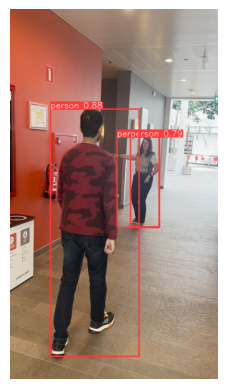

In [5]:
# # Detect person using YOLO
# results = model(img)

# # Display the results
# detect_img = results[0].plot()
# detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

# plt.imshow(detect_img)
# plt.axis('off')
# plt.show()

In [6]:
# Load MiDAS model

# Different MiDAS models:
# Top to Down: Large, more accuracy -> Small, less accurate
#     "DPT_Large"
#     "DPT_Hybrid"
#     "MiDaS_small"

model_type = "MiDaS_small" 
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# If GPU available, map MiDAS execution to GPU else CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)

# Image transformation depending on MiDAS model type
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in C:\Users\esabh/.cache\torch\hub\intel-isl_MiDaS_master
C:\Users\esabh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading weights:  None


Using cache found in C:\Users\esabh/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\esabh/.cache\torch\hub\intel-isl_MiDaS_master


In [14]:
# TODO: Define and use a function to convert inversed depth values to metric distances

# Inverse the depth values from depth map
def inverse_depth_value(depth_value, scale):
    return 1.0 / (depth_value * scale)

# Exponential moving average filter to smoothen depth values
def apply_ema_filter(current_depth, alpha):
    global previous_depth
    filtered_depth = alpha * current_depth + (1 - alpha) * previous_depth
    previous_depth = filtered_depth  # Update the previous depth value
    return filtered_depth

# Get depth map using MiDAS
def get_depth_map(img):
    input_batch = transform(img).to(device)
    # Perform depth prediction using MiDAS
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    # Convert the depth map tensor to a NumPy array for plotting
    depth_map = prediction.cpu().numpy()
    
    return depth_map

eshan_height = 1800

focal_length_sensor_height_ratio = 0.827433
def distance_to_object(real_object_height_mm, image_height_px, object_height_px):
    # return focal_length_mm * real_object_height_mm * image_height_px/ (object_height_px * sensor_height_mm)
    return focal_length_sensor_height_ratio * real_object_height_mm * image_height_px/ (object_height_px)

Text(0.5, 1.0, 'Depth Map')

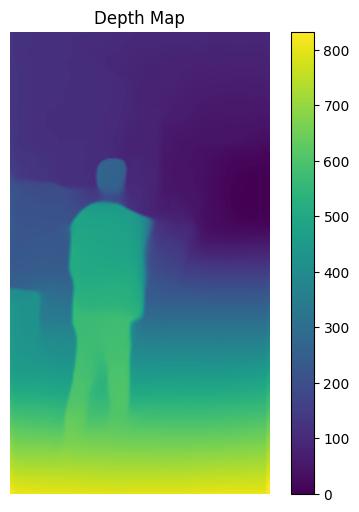

In [54]:
# # Run and view results from depth map function
# depth_map = get_depth_map(img)
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.axis('off')
# plt.imshow(depth_map, cmap='viridis')
# plt.colorbar()
# plt.title('Depth Map')

In [15]:
# Process depth map to get distance 

def process_single_frame(img):
    # Scale for depth inversion
    scale = 0.01 
    alpha = 0.2
    previous_depth = 0.0
    # Detection person using YOLO
    results = model(img)
    # Get depth map 
    #depth_map = get_depth_map(img)
    # Get bounding box of all detected person
    detected_objects = results[0].boxes.xyxy  

    # For now this step iterates through all bounnding boxes, later we need to only use our locked bounding box 
    for obj in detected_objects:
        x1, y1, x2, y2 = obj  # Extract bounding box coordinates
        # object_region_depths = depth_map[int(y1):int(y2), int(x1):int(x2)]  # Extract region from depth map
        # # Calculate mean depth of bounded object
        # depth_value = np.mean(object_region_depths)  
        # # Inverse the depth value
        # depth_value = inverse_depth_value(depth_value, scale)
   
        depth_in_mm = distance_to_object(eshan_height, img.shape[0], y2-y1)

        # Draw a rectangle and print depth value under the bounding box
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        font = cv2.FONT_HERSHEY_SIMPLEX
        depth_text = f"{depth_in_mm:.2f}"
        cv2.putText(img, depth_text, (int(x1), int(y2+15)), font, 0.7, (0,0,0), 2, cv2.LINE_AA)

    return img 


0: 640x384 3 persons, 377.2ms
Speed: 12.3ms preprocess, 377.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


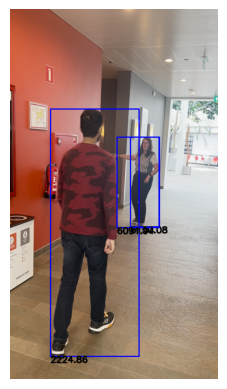

In [16]:
# Run the algorithm for one image

# image = cv2.imread(path)
# detection = process_single_frame(image)
# detection = cv2.cvtColor(detection, cv2.COLOR_RGB2BGR)
# plt.imshow(detection)
# plt.axis('off')
# plt.show()

In [18]:
def process_frame(frame):
    og_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = og_frame.copy()
    classes = [0]   # Person class
    result = model(frame, device=device, classes=classes)
    
    #depth_map = get_depth_map(frame)

    boxes = result[0].boxes  # Boxes object for bbox outputs
    probs = result[0].probs  # Class probabilities for classification outputs
    cls = boxes.cls.tolist()  # Convert tensor to list
    conf = boxes.conf
    xywh = boxes.xywh  # box with xywh format

    pred_cls = np.array(cls)
    conf = conf.detach().cpu().numpy()
    bboxes_xywh = xywh
    bboxes_xywh = xywh.cpu().numpy()
    bboxes_xywh = np.array(bboxes_xywh, dtype=float)

    tracks = tracker.update(bboxes_xywh, conf, og_frame) # setting up the tracker

    for track in tracker.tracker.tracks:
        if(track.track_id == 1):
            hits = track.hits
            # Get bounding box coordinates in (x1, y1, x2, y2) format
            x1, y1, x2, y2 = track.to_tlbr()  
            depth_in_mm = distance_to_object(eshan_height, frame.shape[0], y2-y1)
            # Extract bounding box region from depth map
            #object_region_depths = depth_map[int(y1):int(y2), int(x1):int(x2)]  
            # Calculate mean depth of bounded object
            # depth_value = np.mean(object_region_depths)  
            # # Inverse the depth value
            # depth_value = inverse_depth_value(depth_value, scale)
            # depth_value = (apply_ema_filter(depth_value, alpha))
            # Draw a rectangle and print depth value under the bounding box
            cv2.rectangle(og_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
            font = cv2.FONT_HERSHEY_SIMPLEX
            depth_text = f"{depth_in_mm:.2f}"
            cv2.putText(og_frame, depth_text, (int(x1), int(y2+25)), font, 1, (0,0,0), 2, cv2.LINE_AA)

    return og_frame

In [20]:
# Run the algorithm for a video
from deep_sort.utils.parser import get_config
from deep_sort.deep_sort import DeepSort
from deep_sort.sort.tracker import Tracker

# Set input and output video path
video_path = "videos/video_4.mov"
output_path = "output/video_4_output.mp4"

# Load DeepSORT model
deep_sort_weights = 'deep_sort/deep/checkpoint/ckpt.t7' #load the pretrained model
tracker = DeepSort(model_path=deep_sort_weights, max_age=2000)
classes = [0]  # Person
class_name = 'person'

# Get the video properties
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
# Define the output format and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
# Initialise variables
i = 0
counter, fps, elapsed = 0, 0, 0
start_time = time.perf_counter()
# Scale for depth inversion
scale = 0.01 
alpha = 0.2
previous_depth = 0.0
while True:
    ret, frame = cap.read()
    if ret:
        # Get and display depth from frame
        og_frame = process_frame(frame)

        # Update FPS and place on frame
        current_time = time.perf_counter()
        elapsed = (current_time - start_time)
        counter += 1
        if elapsed > 1:
            fps = counter / elapsed
            counter = 0
            start_time = current_time

        # Write the frame to the output video file
        out.write(cv2.cvtColor(og_frame, cv2.COLOR_RGB2BGR))
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()


0: 640x384 2 persons, 310.6ms
Speed: 8.1ms preprocess, 310.6ms inference, 10.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 345.5ms
Speed: 6.8ms preprocess, 345.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 365.2ms
Speed: 0.0ms preprocess, 365.2ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 315.6ms
Speed: 14.0ms preprocess, 315.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 290.7ms
Speed: 0.0ms preprocess, 290.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 314.2ms
Speed: 2.4ms preprocess, 314.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 312.0ms
Speed: 1.1ms preprocess, 312.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 314.6ms
Speed: 3.8ms preprocess, 314.6ms inference, 9.5ms postprocess pe

In [21]:
# Deep SORT testing
# Set input and output video path
# video_path = "videos/video_4.mov"
# output_path = "output/video_4_output_1.mp4"

# # Load DeepSORT model
# deep_sort_weights = 'deep_sort/deep/checkpoint/ckpt.t7' #load the pretrained model
# tracker = DeepSort(model_path=deep_sort_weights, max_age=2000)
# classes = [0]  # Person
# class_name = 'person'

# # Get the video properties
# cap = cv2.VideoCapture(video_path)
# frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# fps = cap.get(cv2.CAP_PROP_FPS)
# # Define the output format and create VideoWriter object
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
# # Initialise variables
# frames = []
# unique_track_ids = set() 
# i = 0
# counter, fps, elapsed = 0, 0, 0
# start_time = time.perf_counter()


# while True:
#     ret, frame = cap.read()
#     if ret:
#         og_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         frame = og_frame.copy()

#         result = model(frame, device=device, classes=classes, conf=0.5)

#         boxes = result[0].boxes  # Boxes object for bbox outputs
#         probs = result[0].probs  # Class probabilities for classification outputs
#         cls = boxes.cls.tolist()  # Convert tensor to list
#         conf = boxes.conf
#         xywh = boxes.xywh  # box with xywh format

#         pred_cls = np.array(cls)
#         conf = conf.detach().cpu().numpy()
#         bboxes_xywh = xywh
#         bboxes_xywh = xywh.cpu().numpy()
#         bboxes_xywh = np.array(bboxes_xywh, dtype=float)

#         tracks = tracker.update(bboxes_xywh, conf, og_frame) # setting up the tracker

#         for track in tracker.tracker.tracks:
#             track_id = track.track_id
#             hits = track.hits
#             x1, y1, x2, y2 = track.to_tlbr()  # Get bounding box coordinates in (x1, y1, x2, y2) format

#             # Set unique track id based color
#             color = (255,0,0)
#             # draw the tracking box
#             cv2.rectangle(og_frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
#             text_color = (255, 255, 255)  # Black color for text
#             cv2.putText(og_frame, f"{class_name}-{track_id}", (int(x1) + 10, int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, text_color, 1, cv2.LINE_AA)
#             # Add the track_id to the set of unique track IDs
#             unique_track_ids.add(track_id)

#         # Update the person count based on the number of unique track IDs
#         person_count = len(unique_track_ids)

#         # Update FPS and place on frame
#         current_time = time.perf_counter()
#         elapsed = (current_time - start_time)
#         counter += 1
#         if elapsed > 1:
#             fps = counter / elapsed
#             counter = 0
#             start_time = current_time

#         # Draw person count on frame
#         cv2.putText(og_frame, f"People Count: {person_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

#         # Append the frame to the list
#         frames.append(og_frame)

#         # Write the frame to the output video file
#         out.write(cv2.cvtColor(og_frame, cv2.COLOR_RGB2BGR))
#     else:
#         break

# cap.release()
# out.release()
# cv2.destroyAllWindows()


0: 640x384 2 persons, 410.5ms
Speed: 3.0ms preprocess, 410.5ms inference, 10.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 350.1ms
Speed: 3.3ms preprocess, 350.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 345.9ms
Speed: 8.9ms preprocess, 345.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 327.3ms
Speed: 3.2ms preprocess, 327.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 337.2ms
Speed: 0.0ms preprocess, 337.2ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 322.8ms
Speed: 12.4ms preprocess, 322.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 336.8ms
Speed: 3.2ms preprocess, 336.8ms inference, 11.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 353.7ms
Speed: 7.0ms preprocess, 353.7ms inference, 3.0ms postprocess p